---
title: Semantic Segmentation 
author: João G. A. Amorim
date: October 09, 2022
jupyter: python3
---

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/lapix-ufsc/dl-tutorials/blob/main/tutorials/Evaluation/torchmetrics/Semantic_Segmentation.ipynb)

## Imports

In [ ]:
!pip install torchmetrics
!pip install lapixdl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchmetrics
from lapixdl.evaluation.model import SegmentationMetrics

## Create input and output example

-> pred: Predictions from model (probabilities, logits or labels) - at this example we will use labels.

-> target: Ground truth values

In [ ]:
pred = torch.zeros((100, 100), dtype=torch.uint8)
pred[:10, :10] = 1
pred[40:50, 40:50] = 2
pred

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

In [ ]:
target = torch.zeros((100, 100), dtype=torch.uint8)

target[:10, :10] = 1
target[80:90, 80:90] = 3
target

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

Just create utilies tools, a map between category id and the category name, and the number of classes.

In [ ]:
id2label = {0: "background", 1: "A", 2: "B", 3: "C"}

num_classes = len(id2label)

num_classes, id2label

(4, {0: 'background', 1: 'A', 2: 'B', 3: 'C'})

## Plot the prediction and target for demo visualization

Convert the tensors into numpy array

In [ ]:
pred_array = pred.numpy()
target_array = target.numpy()

Load a cmap and ensure to have just the number of classes size. Also build a handle for the legend of the figures

In [ ]:
cmap = matplotlib.cm.get_cmap("Pastel1")

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name=cmap.name,
    colors=[color for idx, color in zip(range(num_classes), cmap.colors)],
    N=num_classes,
)

legend_elements = [
    matplotlib.patches.Patch(
        color=cmap(idx),
        label=f"{id}: {name}",
    )
    for idx, (id, name) in enumerate(id2label.items())
]

Create a figure, and plot target and prediction side by side.

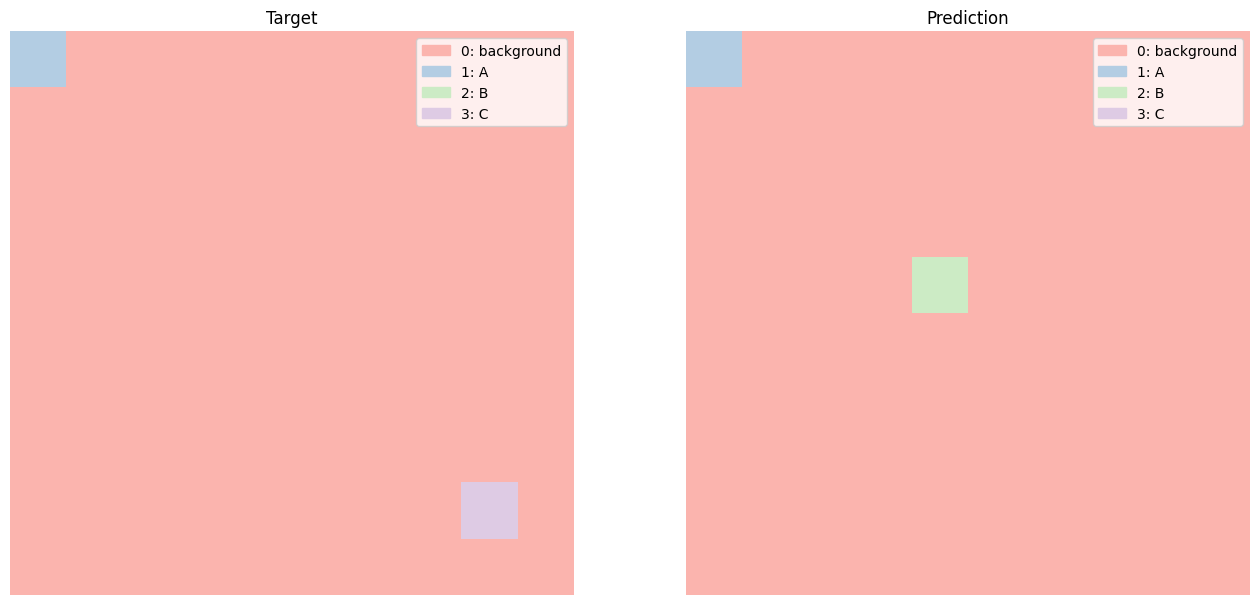

In [ ]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2, sharey=True, sharex=True, figsize=(16, 9), dpi=100
)

ax1.imshow(target_array, cmap=cmap, vmax=max(id2label), vmin=min(id2label))
ax1.legend(handles=legend_elements)
ax1.axis("off")
ax1.set_title("Target")

ax2.imshow(pred_array, cmap=cmap, vmax=max(id2label), vmin=min(id2label))
ax2.legend(handles=legend_elements)
ax2.axis("off")
ax2.set_title("Prediction")

plt.show()

## Compute metrics with `torchmetrics`

For semantic segmentation we can use the `classification` module to compute the desired metrics.



The metrics have practically the same configuration parameters (to be sure, check the docs of each metric). They are:

- average=
  - 'none' : output will be the metric for each category
  - 'macro': the metric is calculate for each class separately, and average the metrics across classes (with equal weights for each class).
- mdmc_reduce or mdmc_average=
  - 'global': will flatten the inputs, and them apply the `average` as usual. 
  - None: Should be left unchanged if your data is not multi-dimensional multi-class.
- ignore_index=
  - Integer specifying a target class to ignore.
- num_classes=
  - Number of classes.
- threshold=
  - Threshold for transforming probability or logit predictions to binary (0,1) predictions, in the case of binary or multi-label inputs. Default value of 0.5 corresponds to input being probabilities.

### Compute the confusion matrix parameter (tp, fp, tn, fn)


This can be done using `stat_scores`from torch metrics, you can found more at the [official docs](https://torchmetrics.readthedocs.io/en/stable/classification/stat_scores.html). If desires the confusion matrix, check the [official docs of confusion matrix](https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html?highlight=confusion%20matrix).

The `reduce` parameter will define the reduction which will be applied. The "macro" value will compute the statistics for each class separately.

The `mdmc_reduce` will be **required** because we are working with a tensor which represent an image. The "global" value will flatten the inputs, and them apply the `reduce` as usual. 

The `num_classes`, the number/quantity of classes is necessary for multicategorical data.



With `reduce='macro'` and `mdmc_reduce='global'` the output will be in the shape: (num_classes, 5). Where this 5 values will be `TP`, `FP`, `TN`, `FN`, sup (sup stands for support and equals to: TP + FN).


In [ ]:
stat = torchmetrics.functional.stat_scores(
    pred, target, reduce="macro", mdmc_reduce="global", num_classes=num_classes
)
stat

tensor([[9700,  100,  100,  100, 9800],
        [ 100,    0, 9900,    0,  100],
        [   0,  100, 9900,    0,    0],
        [   0,    0, 9900,  100,  100]])

We can do a pretty print of this matrix for demonstration only.

In [ ]:
out_sequence = ["TP", "FP", "TN", "FN", "sup"]

print(" " * 10 + "\t" + "\t | \t".join([f"{t}" for t in out_sequence]))
for idx, name in enumerate(id2label.values()):
    txt = "\t | \t".join([f"{v:<5}" for v in stat[idx]])
    print(f"{name:<10} |\t{txt}")

          	TP	 | 	FP	 | 	TN	 | 	FN	 | 	sup
background |	9700 	 | 	100  	 | 	100  	 | 	100  	 | 	9800 
A          |	100  	 | 	0    	 | 	9900 	 | 	0    	 | 	100  
B          |	0    	 | 	100  	 | 	9900 	 | 	0    	 | 	0    
C          |	0    	 | 	0    	 | 	9900 	 | 	100  	 | 	100  


### Accuracy

[Official docs](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)

First needs to init the metric class, and after you can pass the `pred` and `target` tensor to compute the metric values.

The output shape in this case will be (num_classes), where each position of the tensor is equals to the IoU of each category. 


If you desire to have the metric for each category, just use `average='none'`. 

In [ ]:
acc = torchmetrics.classification.Accuracy(
    average="none", mdmc_reduce="global", num_classes=num_classes
)
acc(pred, target)

tensor([0.9898, 1.0000, 0.0000, 0.0000])

If you desire to ignore the value of some specific category, you can use `ignore_index`.

In [ ]:
acc = torchmetrics.classification.Accuracy(
    average="none", mdmc_reduce="global", num_classes=num_classes, ignore_index=0
)
acc(pred, target)

tensor([nan, 1., 0., 0.])

Using `average='macro'` the metric is calculate for each class separately, and average the metrics across classes (with equal weights for each class).

In [ ]:
acc = torchmetrics.classification.Accuracy(
    average="macro", mdmc_reduce="global", num_classes=num_classes, ignore_index=0
)
acc(pred, target)

tensor(0.3333)

### Jaccard Index | Intersection over Union (IoU)

[Official docs](https://torchmetrics.readthedocs.io/en/stable/classification/jaccard_index.html)

In this case, if you desire to have the metric for each category, just use `average='none'`. 

First needs to init the metric class, and after you can pass the `pred` and `target` tensor to compute the metric values.

The output shape in this case will be (num_classes), where each position of the tensor is equals to the IoU of each category. 

In [ ]:
jaccard = torchmetrics.classification.JaccardIndex(
    average="none", num_classes=num_classes
)
jaccard(pred, target)

tensor([0.9798, 1.0000, 0.0000, 0.0000])

Using `average='macro'` the metric is calculate for each class separately, and average the metrics across classes (with equal weights for each class).

In [ ]:
jaccard = torchmetrics.classification.JaccardIndex(
    average="macro", num_classes=num_classes
)
jaccard(pred, target)

tensor(0.4949)

### Dice score | F1-score

[Official docs f1-score](https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html)

[Official docs dice](https://torchmetrics.readthedocs.io/en/stable/classification/dice.html)

Using `average='macro'` the metric is calculate for each class separately, and average the metrics across classes (with equal weights for each class).

The `mdmc_reduce` or `mdmc_average` will be **required** because we are working with a tensor which represent an image. The "global" value will flatten the inputs, and them apply the `average` as usual. 

In [ ]:
f1score = torchmetrics.classification.F1Score(
    average="macro", mdmc_reduce="global", num_classes=num_classes
)
f1score(pred, target)

tensor(0.2724)

In [ ]:
dice = torchmetrics.classification.Dice(
    average="macro", mdmc_average="global", num_classes=num_classes
)
dice(pred, target)

tensor(0.2724)

If you desire to have the metric for each category, just use `average='none'`. 

In [ ]:
dice = torchmetrics.classification.Dice(
    average="none", mdmc_average="global", num_classes=num_classes
)

dice(pred, target)

tensor([0.9898, 1.0000, 0.0000, 0.0000])

### Precision
[Official docs](https://torchmetrics.readthedocs.io/en/stable/classification/precision.html)

In [ ]:
precision = torchmetrics.classification.Precision(
    average="none", mdmc_average="global", num_classes=num_classes
)
precision(pred, target)

tensor([0.9898, 1.0000, 0.0000, 0.0000])

### Recall

[Official docs](https://torchmetrics.readthedocs.io/en/stable/classification/recall.html)

In [ ]:
recall = torchmetrics.classification.Recall(
    average="none", mdmc_average="global", num_classes=num_classes
)
recall(pred, target)

tensor([0.9898, 1.0000, 0.0000, 0.0000])

### Specificity

[Official docs](https://torchmetrics.readthedocs.io/en/stable/classification/specificity.html)

In [ ]:
specificity = torchmetrics.classification.Specificity(
    average="none", mdmc_average="global", num_classes=num_classes
)

specificity(pred, target)

tensor([0.5000, 1.0000, 0.9900, 1.0000])

## Using torchmetrics with lapixdl

The `lapixdl` package calculates the confusion matrix first (on the CPU), which this will be slower than calculating using `torchmetrics` which uses pytorch tensors. So a trick here, to not calculate each metric separately in `torchmetrics`, is to calculate a confusion matrix using `torchmetrics` and then calculate all the metrics at once using `lapixdl`. 

First, compute the confusion matrix with torch metrics

In [ ]:
confMat = torchmetrics.ConfusionMatrix(
    reduce="macro", mdmc_reduce="global", num_classes=num_classes
)

confusion_matrix = confMat(pred, target)
confusion_matrix = confusion_matrix.numpy()
confusion_matrix

array([[9700,    0,  100,    0],
       [   0,  100,    0,    0],
       [   0,    0,    0,    0],
       [ 100,    0,    0,    0]])

Then compute the metrics with lapixdl

In [ ]:
metrics = SegmentationMetrics(
    classes=list(id2label.values()), confusion_matrix=confusion_matrix
)

In [ ]:
metrics.to_dataframe()

,Average,background,A,B,C
Accuracy,0.980000,0.98,1.0,0.99,0.99
Recall,0.663265,0.9897959183673469,1.0,0.0,No positive cases in GT
Precision,0.497449,0.989796,1,NaN,0.0
Specificity,0.872500,0.5,1.0,1.0,0.99
F-Score,0.497449,0.989796,1.0,0.0,0.0
FPR,0.127500,0.5,0.0,0.0,0.01
IoU,0.494949,0.979798,1.0,0.0,0.0
IoU w/o Background,0.333333,NaN,NaN,NaN,NaN
TP,NaN,9700,100,0,0
TN,NaN,100,9900,9900,9900
